# <font color=darkred> Première prédiction bougie haussière ou baissière  </font>

### <font color=darkblue> Etape 1 : Nettoyer le jeu de données et créer le label des individus  </font>

In [36]:
%matplotlib inline
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from numpy import concatenate
from keras.utils import to_categorical
from math import sqrt

La première étape consiste à récupérer les données et nettoyer le dataset.

In [37]:
df = pd.read_csv('/Users/renaudleurquin/Documents/TSP/2A/Cassiopé/BDD/FDAX_indicateurs.txt', sep='\t', skipinitialspace=True)
#df_vol = pd.read_csv('/Users/renaudleurquin/Documents/TSP/2A/Cassiopé/BDD/FDAX_indicateurs.txt', sep='\t', skipinitialspace=True)
#skipinitialspace permet de retirer les espaces génants sur les colonnes et sur les données

#suppression des colonnes non utiles à la prédiction
colonnes = ['Volume', '# of Trades','OHLC Avg', 'HLC Avg', 'HL Avg', 'Bid Volume', 'Ask Volume', 'Open.1','High.1', 'Low.1', 'Close', "etat variable 'Volume'","etat variable 'DeltaSpread'", "etat variable 'PriceChange'","etat variable 'Delta'", 'volume', 'deltaSpread', 'priceChange','delta', "etat variable 'spread'", "etat variable 'open'","etat variable 'close'", "etat variable 'deltaOpen'","etat variable 'deltaClose'", 'weak', 'strong', 'Strong Triangle','weak Triangle', 'delta_sos', 'delta_sow', "Signal d'achat",'Signal de vente', 'trendFilter']
df.drop(colonnes, axis = 1, inplace = True)

df['Date&Time'] = df['Date'] +' '+ df['Time']
df['date_time'] = pd.to_datetime(df['Date&Time'], format='%d/%m/%Y %H:%M:%S.%f')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')
df.drop(['Date', 'Date&Time'], axis=1, inplace=True)
df = df[['date_time', 'Time', 'Open', 'High', 'Low', 'Last']]
df

,date_time,Time,Open,High,Low,Last
0,2013-01-04 08:00:00,1900-01-01 08:00:00,7842.0,7844.5,7839.5,7840.5
1,2013-01-04 08:05:00,1900-01-01 08:05:00,7840.0,7842.0,7837.0,7838.0
2,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,7836.5
3,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,7839.5
4,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,7837.0
...,...,...,...,...,...,...
296602,2019-12-11 21:40:00,1900-01-01 21:40:00,13144.5,13150.0,13144.0,13149.5
296603,2019-12-11 21:45:00,1900-01-01 21:45:00,13150.0,13153.0,13143.0,13144.5
296604,2019-12-11 21:50:00,1900-01-01 21:50:00,13145.0,13155.0,13145.0,13154.5
296605,2019-12-11 21:55:00,1900-01-01 21:55:00,13153.0,13154.0,13147.5,13151.0


Comme nous allons utiliser une régression softmax, il faut créer la variable Y indiquant le label des individus. Nous choissons pour la suite de ce projet que cette variable se définit comme cela :
- $Y = 1$ si la bougie considérée est haussière, c'est-à-dire si le Last à l'instant $t$ est supérieur au Last à l'instant $t-1$ ; 
- $Y = 0$ si la bougie clôture exactement à la même valeur que la bougie présédente (égalité des Last) ;
- $Y = -1$ si la bougie considérée est baissière, c'est-à-dire si le Last à l'instant $t$ est inférieur au Last à l'instant $t-1$.

Nous devons donc itérer sur l'ensemble des lignes du dataframe, chaque ligne représentant les informations d'un chandelier japonais dans une tranche de 5min, dans le but d'assimiler à chaque individu, son label. 


In [38]:
Y=[]
n = df.shape[0]
for i in range (1,n) : 
    if df.iloc[i,5]<df.iloc[i-1,5]:
        Y.append(-1)
    if df.iloc[i,5]==df.iloc[i-1,5]:
        Y.append(0)
    if df.iloc[i,5]>df.iloc[i-1,5]:
        Y.append(1) 

Remarquons que ce calcul s'appuie, pour chaque bougie considérée, sur la valeur du Last de la bougie précédente. Ainsi, la première ligne du dataframe n'aura pas de label associé, il convient donc avant d'ajouter la colonne Y au dataframe, de supprimer la première ligne pour ne pas avoir de décalage dans les données. 

In [39]:
l = len(Y)
print("La longueur de la liste des labels est : %s" %l)
print("La longueur du dataframe est : %s" %n)
df = df.iloc[1:,:]
n=df.shape[0]
print()
print("La longueur de la liste des labels est : %s" %l)
print("La longueur du dataframe privé de sa première ligne est : %s" %n)

La longueur de la liste des labels est : 296606
La longueur du dataframe est : 296607

La longueur de la liste des labels est : 296606
La longueur du dataframe privé de sa première ligne est : 296606


In [40]:
df.insert(6,'Y',Y)
df.head(10)

,date_time,Time,Open,High,Low,Last,Y
1,2013-01-04 08:05:00,1900-01-01 08:05:00,7840.0,7842.0,7837.0,7838.0,-1
2,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,7836.5,-1
3,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,7839.5,1
4,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,7837.0,-1
5,2013-01-04 08:25:00,1900-01-01 08:25:00,7837.0,7842.5,7836.5,7840.5,1
6,2013-01-04 08:30:00,1900-01-01 08:30:00,7840.5,7841.5,7839.0,7840.0,-1
7,2013-01-04 08:35:00,1900-01-01 08:35:00,7840.0,7841.0,7839.0,7840.0,0
8,2013-01-04 08:40:00,1900-01-01 08:40:00,7840.0,7841.0,7838.0,7840.0,0
9,2013-01-04 08:45:00,1900-01-01 08:45:00,7840.0,7842.5,7839.0,7842.5,1
10,2013-01-04 08:50:00,1900-01-01 08:50:00,7842.0,7844.0,7840.0,7843.0,1


In [41]:
date_limite = dt.datetime.strptime('2014-01-01 08:00:00.0', '%Y-%m-%d %H:%M:%S.%f')
dix_huit = dt.datetime.strptime('18:05:00.0', '%H:%M:%S.%f')

df_2013 = df.loc[(df["date_time"]<date_limite) & (df["Time"]<dix_huit)]

y1 = (df_2013['Y']==1).value_counts()
y0 = (df_2013['Y']==0).value_counts()
yneg = (df_2013['Y']==-1).value_counts()
print ("Dans ce dataset, on ne considère que l'année 2013 et les valeurs du tape relevées avant 18h00.") 
print("Nous obtenons les résulats suivants:")
print()
print("Il y a %s bougies montantes ;" %(y1[1]))
print()
print("Il y a %s bougies égales ;" %(y0[1]))
print()
print("Il y a %s bougies descendantes." %(yneg[1]))

#Il est nécessaire de changer l'index du dataframe pour le pre-processing des données
index = np.linspace(1,30264, num=30264, dtype='int64')
df_2013.index = index
df_2013.head(10)

Dans ce dataset, on ne considère que l'année 2013 et les valeurs du tape relevées avant 18h00.
Nous obtenons les résulats suivants:

Il y a 14535 bougies montantes ;

Il y a 1608 bougies égales ;

Il y a 14121 bougies descendantes.


,date_time,Time,Open,High,Low,Last,Y
1,2013-01-04 08:05:00,1900-01-01 08:05:00,7840.0,7842.0,7837.0,7838.0,-1
2,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,7836.5,-1
3,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,7839.5,1
4,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,7837.0,-1
5,2013-01-04 08:25:00,1900-01-01 08:25:00,7837.0,7842.5,7836.5,7840.5,1
6,2013-01-04 08:30:00,1900-01-01 08:30:00,7840.5,7841.5,7839.0,7840.0,-1
7,2013-01-04 08:35:00,1900-01-01 08:35:00,7840.0,7841.0,7839.0,7840.0,0
8,2013-01-04 08:40:00,1900-01-01 08:40:00,7840.0,7841.0,7838.0,7840.0,0
9,2013-01-04 08:45:00,1900-01-01 08:45:00,7840.0,7842.5,7839.0,7842.5,1
10,2013-01-04 08:50:00,1900-01-01 08:50:00,7842.0,7844.0,7840.0,7843.0,1


### <font color=darkblue> Etape 2 : Faire le pre-processing des données  </font>

Travailler avec des valeurs numériques importantes peut mener à des erreurs numériques importantes. Les données en entrée du réseau (input variables) doivent donc rester de relativement petites tailles. Il existe deux manières pour transformer ces données : 
- Les uniformiser si les inuput data suivent une distribution normale (il sagit en fait simplement de soustraire la moyenne et diviser par l'écart-type);
- Les normaliser si elles ne suivent pas une distribution gaussienne. 

Ici, nous normalisons les input data en utilisant la méthode MinMaxScaler. Les valeurs normalisées seront toutes comprises entre 0 et 1. 

Concernant les output data (données à prédire, ici Y), il s'agit de données catégorielles qui prennnent leurs valeurs dans {-1, 0, 1}.

In [42]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [43]:
#On exclut la date et l'heure qui ne sont pas des données d'apprentissage et les labels
n = df_2013.shape[0]
limit = int(4*n/5)
values_app = df_2013.iloc[:limit,2:6].values

#Processus de normalisation à partir des données d'apprentissage
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(values_app)

#Normalisation de l'ensemble des données à partir du modèle de normalisation construit sur les données d'apprentissage
values = df_2013.iloc[:,2:6]
normalized = scaler.transform(values)
processed_data = pd.DataFrame(normalized)
colonnes = ['Open', 'High', 'Low', 'Last']
processed_data.columns = colonnes

#J'ai mis tellement de temps à comprendre ce souci 
processed_data.index = processed_data.index+1 #car pour ajouter la colonne Y dans ce nouveau df, il faut que les indices correspondent
processed_data['Y'] = df_2013['Y']
values_processed = processed_data.values #numpy representation des données


#Données d'apprentissage
X_train = values_processed[:limit,:4]
Y_train = values_processed[:limit,4]

#Données de test
X_test = values_processed[limit:,:4]
Y_test = values_processed[limit:,4]

print("Minimum value is %s" %(normalized.min()) )
print("Maximum value is %s" %(normalized.max()) )
print("======================================")
print()
print(X_train.shape[0], ' : number of train samples')
print(X_test.shape[0], ' : number of test samples')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Minimum value is 0.0
Maximum value is 1.531618435155413

24211  : number of train samples
6053  : number of test samples
X_train shape:  (24211, 4)
Y_train shape:  (24211,)
X_test shape:  (6053, 4)
Y_test shape:  (6053,)


In [251]:
#création d'une liste contenant les dates des données du dataframe de test
#Cela permettra de tracer les courbes de prédiction des prix en fonction de la date
df_2013_date = df_2013.iloc[:,0]
print(df_2013_date)
val_date=[]
val_date_train=[]
val_date_test=[]
for i in range (0,30264):
    val_date.append(df_2013_date.iloc[i])
    val_date_train=val_date[2:limit+2]
    val_date_test=val_date[limit+2:]

print(len(val_date))
print(len(val_date_train))
print(len(val_date_test))
val_date_test

1       2013-01-04 08:05:00
2       2013-01-04 08:10:00
3       2013-01-04 08:15:00
4       2013-01-04 08:20:00
5       2013-01-04 08:25:00
                ...        
30260   2013-12-30 17:40:00
30261   2013-12-30 17:45:00
30262   2013-12-30 17:50:00
30263   2013-12-30 17:55:00
30264   2013-12-30 18:00:00
Name: date_time, Length: 30264, dtype: datetime64[ns]
30264
24211
6051


[Timestamp('2013-10-16 18:00:00'),
 Timestamp('2013-10-17 08:00:00'),
 Timestamp('2013-10-17 08:05:00'),
 Timestamp('2013-10-17 08:10:00'),
 Timestamp('2013-10-17 08:15:00'),
 Timestamp('2013-10-17 08:20:00'),
 Timestamp('2013-10-17 08:25:00'),
 Timestamp('2013-10-17 08:30:00'),
 Timestamp('2013-10-17 08:35:00'),
 Timestamp('2013-10-17 08:40:00'),
 Timestamp('2013-10-17 08:45:00'),
 Timestamp('2013-10-17 08:50:00'),
 Timestamp('2013-10-17 08:55:00'),
 Timestamp('2013-10-17 09:00:00'),
 Timestamp('2013-10-17 09:05:00'),
 Timestamp('2013-10-17 09:10:00'),
 Timestamp('2013-10-17 09:15:00'),
 Timestamp('2013-10-17 09:20:00'),
 Timestamp('2013-10-17 09:25:00'),
 Timestamp('2013-10-17 09:30:00'),
 Timestamp('2013-10-17 09:35:00'),
 Timestamp('2013-10-17 09:40:00'),
 Timestamp('2013-10-17 09:45:00'),
 Timestamp('2013-10-17 09:50:00'),
 Timestamp('2013-10-17 09:55:00'),
 Timestamp('2013-10-17 10:00:00'),
 Timestamp('2013-10-17 10:05:00'),
 Timestamp('2013-10-17 10:10:00'),
 Timestamp('2013-10-

Comme les floats $0.0$, $0.5$, et $1.0$ représentant respectivement les valeurs de Y suivantes : $-1$, $0$ et $1$, n'ont pas de relation ordinale et sont simplement des remplaçants des labels "haussiers", "égal" et "baissier", on utilise l'encodage one-hot. Chaque label est alors représenté par un vecteur binaire à 3 dimensions car 3 classes. 

In [12]:
num_class = 3
Y_train = to_categorical(Y_train, num_class)
Y_test = to_categorical(Y_test, num_class)


In [13]:
Y_train[:10,]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [14]:
processed_data.head(10)

,Open,High,Low,Last,Y
1,0.230439,0.229433,0.237522,0.229286,-1
2,0.228653,0.226241,0.234690,0.228214,-1
3,0.227939,0.228014,0.236460,0.230357,1
4,0.230439,0.228014,0.237522,0.228571,-1
5,0.228296,0.229787,0.237168,0.231071,1
6,0.230797,0.229078,0.238938,0.230714,-1
7,0.230439,0.228723,0.238938,0.230714,0
8,0.230439,0.228723,0.238230,0.230714,0
9,0.230439,0.229787,0.238938,0.232500,1
10,0.231869,0.230851,0.239646,0.232857,1


### <font color=darkblue> Etape 3 : Apprentissage  </font>

In [44]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
from keras import activations
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [107]:
def modelling():
    model = Sequential()
    model.add(Dense(num_class, activation='softmax', name='dense_softmax'))
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adagrad(),
        metrics=['accuracy'])
    return(model)

batch_size = 64
epochs = 50

# Run the train
model = modelling()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 24211 samples, validate on 6053 samples
Epoch 1/50
24211/24211 [==============================] - 0s 16us/step - loss: 0.9681 - accuracy: 0.4659 - val_loss: 0.8984 - val_accuracy: 0.4618
Epoch 2/50
24211/24211 [==============================] - 0s 15us/step - loss: 0.8948 - accuracy: 0.4672 - val_loss: 0.9039 - val_accuracy: 0.4618
Epoch 3/50
24211/24211 [==============================] - 0s 13us/step - loss: 0.8807 - accuracy: 0.4671 - val_loss: 0.9139 - val_accuracy: 0.4618
Epoch 4/50
24211/24211 [==============================] - 0s 14us/step - loss: 0.8750 - accuracy: 0.4792 - val_loss: 0.9240 - val_accuracy: 0.4618
Epoch 5/50
24211/24211 [==============================] - 0s 13us/step - loss: 0.8722 - accuracy: 0.4727 - val_loss: 0.9296 - val_accuracy: 0.4581
Epoch 6/50
24211/24211 [==============================] - 0s 14us/step - loss: 0.8706 - accuracy: 0.4816 - val_loss: 0.9345 - val_accuracy: 0.4565
Epoch 7/50
24211/24211 [==============================] - 0s 15us/ste

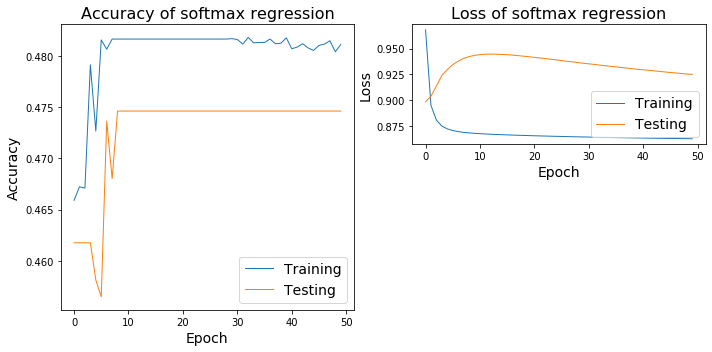

In [108]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.epoch, history.history['accuracy'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=1, label='Testing')
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(222)
plt.plot(history.epoch, history.history['loss'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=1, label='Testing')
plt.title('Loss of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend(fontsize=14)


plt.tight_layout()

### <font color=darkblue> Etape 4 : Optimiser les hyper-paramètres pour avoir un benchmark et un résultat à dépasser  </font>

In [155]:
est = KerasClassifier(build_fn=modelling)

param = {'batch_size' : [4,8,16,32,64,128,256],
         'epochs' : [10,50,100]}

gr_sr = GridSearchCV(         #GridSearchCV considers all hyper-parameters combinations
    estimator=est,
    param_grid=param,
    n_jobs=-1,     #means that use all available computing power
    cv=3,)         #number of folds for cross validation
    

gr_sr.fit(X_train,Y_train) 


ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (16140, 4)

In [153]:
gr_sr.summary()

NameError: name 'gr_sr' is not defined

In [111]:
print("The best parameters found are the following ones:")
print(gr_sr.best_params_)

The best parameters found are the following ones:
{'batch_size': 128, 'epochs': 50}


Test loss: 0.9350454752137597
Test accuracy: 0.4746406674385071


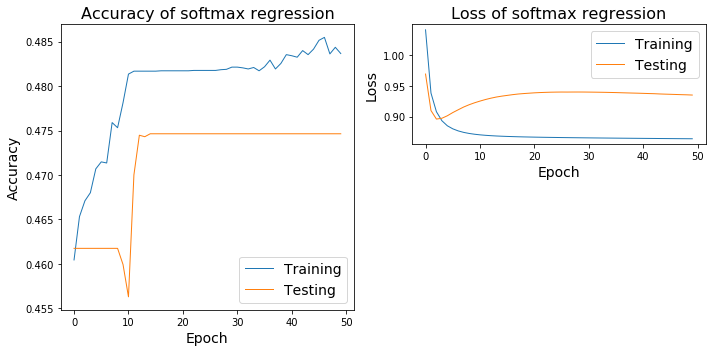

In [120]:
batch_size, epochs = 128, 50

# Run the train
model = modelling()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_test, Y_test))
score = model.evaluate(X_test,Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.epoch, history.history['accuracy'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=1, label='Testing')
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(222)
plt.plot(history.epoch, history.history['loss'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=1, label='Testing')
plt.title('Loss of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend(fontsize=14)


plt.tight_layout()

Ce qui est étonnant est que le modèle "non optimisé" était meilleur (même valeur de l'accuracy mais plus petite valeur de la loss). Ces résultats avait été obtenus avec batch_size = 64 et epochs = 50. Cette combinaison a pourtant été testée avec le GridSearch… Mystère …

# <font color=darkred> Partie 2 : Mise en place d'un LSTM pour prédire la valeur du Last </font>

L'objectif de cette partie est de prédire la valeur du Last $y_t$ à l'instant $t$ en fonction des observations précédentes. A chaque pas de temps, la valeur estimée de $y_t$ qu'on note $\hat{y}_t$, est obtenue en utilisant l'état caché à l'instant précédent $h_{t-1}$ et les données d'entrée $x_t$ à l'instant $t$. Ces données en entrée correspondent aux 3 features Open, High et Low.
En fonction du pas de temps considéré, les données d'entrée ne seront pas les mêmes. Voici un exemple : 
- $time$_$lag = 0$ : les données d'entrée sont constituées des 3 features à l'instant $t$;
- $time$_$lag = 1$ : les données d'entrée sont constituées des 3 features à l'instant $t$ et de l'ensemble des features à l'instant $t-1$ (les 3 + le Last) ;
- $time$_$lag = 2$ : les données d'entrée sont constituées des 3 features à l'instant $t$ et de l'ensemble des features à l'instant $t-1$ et à l'instant $t-2$ (les 3 + le Last) ;

La fonction $build$_$dataset$ construit le dataset des données pour un time_lag donné.

In [45]:
def build_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
time_lag = 1
scaled = normalized
processed_data_lstm = build_dataset(scaled, time_lag, 1)
values = processed_data_lstm.values
processed_data_lstm

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.230439,0.229433,0.237522,0.229286,0.228653,0.226241,0.234690,0.228214
2,0.228653,0.226241,0.234690,0.228214,0.227939,0.228014,0.236460,0.230357
3,0.227939,0.228014,0.236460,0.230357,0.230439,0.228014,0.237522,0.228571
4,0.230439,0.228014,0.237522,0.228571,0.228296,0.229787,0.237168,0.231071
5,0.228296,0.229787,0.237168,0.231071,0.230797,0.229078,0.238938,0.230714
...,...,...,...,...,...,...,...,...
30259,1.521972,1.515248,1.518938,1.525000,1.524830,1.514539,1.521416,1.525357
30260,1.524830,1.514539,1.521416,1.525357,1.525188,1.518085,1.522478,1.527500
30261,1.525188,1.518085,1.522478,1.527500,1.527688,1.517730,1.524248,1.529286
30262,1.527688,1.517730,1.524248,1.529286,1.529475,1.517730,1.524602,1.529286


In [15]:
train = values[:limit, :]
test = values[limit:, :]

# split into input and outputs
X_train_lstm, Y_train_lstm = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
X_test_lstm, Y_test_lstm = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))



In [16]:
print('x_train shape:', X_train_lstm.shape)
print('x_test shape:', X_test_lstm.shape)
print('y_train shape:', Y_train_lstm.shape)
print('y_test shape:', Y_test_lstm.shape)

x_train shape: (24211, 1, 3)
x_test shape: (6053, 1, 3)
y_train shape: (24211,)
y_test shape: (6053,)


In [31]:
model = Sequential()
model.add(LSTM(10, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

In [32]:
batch_size = 64
epochs = 200
history = model.fit(X_train_lstm, Y_train_lstm,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = 1,
                    validation_data=(X_test_lstm, Y_test_lstm))
score = model.evaluate(X_test_lstm, Y_test_lstm, verbose = 1)

Train on 24211 samples, validate on 6053 samples
Epoch 1/200
24211/24211 [==============================] - 1s 48us/step - loss: 0.0534 - accuracy: 8.2607e-05 - val_loss: 0.0170 - val_accuracy: 8.2604e-04
Epoch 2/200
24211/24211 [==============================] - 1s 27us/step - loss: 0.0036 - accuracy: 8.2607e-05 - val_loss: 0.0336 - val_accuracy: 8.2604e-04
Epoch 3/200
24211/24211 [==============================] - 1s 27us/step - loss: 0.0028 - accuracy: 8.2607e-05 - val_loss: 0.0316 - val_accuracy: 8.2604e-04
Epoch 4/200
24211/24211 [==============================] - 1s 26us/step - loss: 0.0027 - accuracy: 8.2607e-05 - val_loss: 0.0295 - val_accuracy: 8.2604e-04
Epoch 5/200
24211/24211 [==============================] - 1s 27us/step - loss: 0.0026 - accuracy: 8.2607e-05 - val_loss: 0.0261 - val_accuracy: 8.2604e-04
Epoch 6/200
24211/24211 [==============================] - 1s 27us/step - loss: 0.0026 - accuracy: 8.2607e-05 - val_loss: 0.0279 - val_accuracy: 8.2604e-04
Epoch 7/200
242

Epoch 53/200
24211/24211 [==============================] - 1s 28us/step - loss: 0.0019 - accuracy: 8.2607e-05 - val_loss: 0.0083 - val_accuracy: 8.2604e-04
Epoch 54/200
24211/24211 [==============================] - 1s 32us/step - loss: 0.0019 - accuracy: 8.2607e-05 - val_loss: 0.0075 - val_accuracy: 8.2604e-04
Epoch 55/200
24211/24211 [==============================] - 1s 32us/step - loss: 0.0019 - accuracy: 8.2607e-05 - val_loss: 0.0086 - val_accuracy: 8.2604e-04
Epoch 56/200
24211/24211 [==============================] - 1s 33us/step - loss: 0.0019 - accuracy: 8.2607e-05 - val_loss: 0.0089 - val_accuracy: 8.2604e-04
Epoch 57/200
24211/24211 [==============================] - 1s 34us/step - loss: 0.0019 - accuracy: 8.2607e-05 - val_loss: 0.0089 - val_accuracy: 8.2604e-04
Epoch 58/200
24211/24211 [==============================] - 1s 32us/step - loss: 0.0019 - accuracy: 8.2607e-05 - val_loss: 0.0088 - val_accuracy: 8.2604e-04
Epoch 59/200
24211/24211 [==============================] 

24211/24211 [==============================] - 1s 33us/step - loss: 0.0016 - accuracy: 8.2607e-05 - val_loss: 0.0078 - val_accuracy: 8.2604e-04
Epoch 157/200
24211/24211 [==============================] - 1s 30us/step - loss: 0.0016 - accuracy: 8.2607e-05 - val_loss: 0.0085 - val_accuracy: 8.2604e-04
Epoch 158/200
24211/24211 [==============================] - 1s 37us/step - loss: 0.0016 - accuracy: 8.2607e-05 - val_loss: 0.0059 - val_accuracy: 8.2604e-04
Epoch 159/200
24211/24211 [==============================] - 1s 31us/step - loss: 0.0016 - accuracy: 8.2607e-05 - val_loss: 0.0070 - val_accuracy: 8.2604e-04
Epoch 160/200
24211/24211 [==============================] - 1s 30us/step - loss: 0.0016 - accuracy: 8.2607e-05 - val_loss: 0.0074 - val_accuracy: 8.2604e-04
Epoch 161/200
24211/24211 [==============================] - 1s 36us/step - loss: 0.0016 - accuracy: 8.2607e-05 - val_loss: 0.0093 - val_accuracy: 8.2604e-04
Epoch 162/200
24211/24211 [==============================] - 1s 33

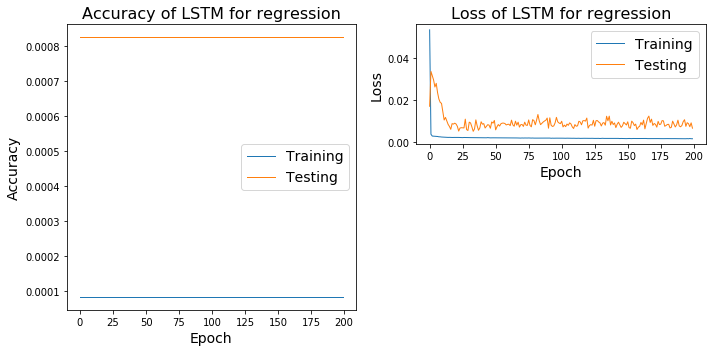

In [33]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.epoch, history.history['accuracy'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=1, label='Testing')
plt.title('Accuracy of LSTM for regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(222)
plt.plot(history.epoch, history.history['loss'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=1, label='Testing')
plt.title('Loss of LSTM for regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend(fontsize=14)


plt.tight_layout()

### <font color = darkblue> Réalisation d'une validation croisée pour optimiser les hyper-paramètres et obtenir le modèle le plus précis au sens de la MAE </font>

Considérons des valeurs de $time$_$lag$ supérieures à 0 pour obtenir de meilleurs résultats. Pour cela nous construisons la fonction $data$ qui permet de récupérer les samples d'entrainement (X_train_lstm, Y_train_lstm) et de test (X_test_lstm, Y_test_lstm) en fonction du pas de temps que l'on souhaite considérer : $time$_$lag$. 

Nous allons chercher les meilleurs hyper-paramètres pour ce modèle en considérant à chaque fois un time_lag différent. Nous ne ferons varier que la dimension de la couche cachée. 

In [17]:
time_lag = 1
scaled_test = normalized
processed_data_lstm_test = build_dataset(scaled, time_lag, 1)
values_test = processed_data_lstm_test.values
processed_data_lstm_test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.230439,0.229433,0.237522,0.229286,0.228653,0.226241,0.234690,0.228214
2,0.228653,0.226241,0.234690,0.228214,0.227939,0.228014,0.236460,0.230357
3,0.227939,0.228014,0.236460,0.230357,0.230439,0.228014,0.237522,0.228571
4,0.230439,0.228014,0.237522,0.228571,0.228296,0.229787,0.237168,0.231071
5,0.228296,0.229787,0.237168,0.231071,0.230797,0.229078,0.238938,0.230714
...,...,...,...,...,...,...,...,...
30259,1.521972,1.515248,1.518938,1.525000,1.524830,1.514539,1.521416,1.525357
30260,1.524830,1.514539,1.521416,1.525357,1.525188,1.518085,1.522478,1.527500
30261,1.525188,1.518085,1.522478,1.527500,1.527688,1.517730,1.524248,1.529286
30262,1.527688,1.517730,1.524248,1.529286,1.529475,1.517730,1.524602,1.529286


In [18]:
def data (time_lag): #time_lag = parameter to design how many time steps to consider in the input data 
    scaled = normalized
    processed_data_lstm = build_dataset(scaled, time_lag, 1)
    # split into train and test sets
    values = processed_data_lstm.values  #values is a numpy representation of processed_data, which is data normalized for prediction
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    X_train_lstm, Y_train_lstm = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
    X_test_lstm, Y_test_lstm = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))
    return(X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm)  

def modelling_lstm(lstm_dim=4):
    model = Sequential()
    model.add(LSTM(lstm_dim, input_shape=(X_train_lstm.shape[1], X_test_lstm.shape[2])))
    model.add(Dense(1))
    model.compile(loss = 'mae', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return(model)



La cellule suivante permet de faire une validation croisée pour sélectionner la meilleure dimension de la couche cachée du LSTM, quand. le time_lag considéré varie de 1 à 3, c'est-à-dire que la dimension des données d'entrée est différente. Ici, nous nous intéressons à la corrélation entre la dimension de la couche cachée du LSTM et la valeur du time_lag : ce sont les seuls paramètres qui varient. Le batch_size et le nombre d'epochs seront discutés une fois que pour chaque valeur du time_lag, la dimension optimale de la couche cachée sera obtenue.

Attention: Le paramètre refit de la fonction $GridSearchCV()$ doit être forcé à $False$, car il est en dehors de la boucle. Autrement, à chaque passage dans la boucle, l'estimateur serait remodellé avec les paramètres précédemment obtenus, ce qui compromettrait le résultat. 

In [27]:
estimator_lstm = KerasRegressor(build_fn=modelling_lstm, batch_size=64, epochs=50)
param_grid_lstm = {'lstm_dim':[4, 8, 16, 32, 64, 128]}
clf_lstm_test=GridSearchCV(estimator=estimator_lstm, param_grid=param_grid_lstm, n_jobs=-1, cv=3, refit=False)

for i in range (1,4):
    time_lag=i
    X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = data(time_lag)
    clf_lstm_test.fit(X_train_lstm, Y_train_lstm)
    print("For time_lag = %s :" %(time_lag))
    print("Best parameters set found on development set for a time lag equal to %s:" %time_lag)
    print()
    print(clf_lstm_test.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_lstm_test.cv_results_['mean_test_score']
    stds = clf_lstm_test.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_lstm_test.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("=============================================")
    print()

For time_lag = 1 :
Best parameters set found on development set for a time lag equal to 1:

{'lstm_dim': 16}

Grid scores on development set:

-0.002 (+/-0.001) for {'lstm_dim': 4}
-0.002 (+/-0.001) for {'lstm_dim': 8}
-0.002 (+/-0.000) for {'lstm_dim': 16}
-0.003 (+/-0.003) for {'lstm_dim': 32}
-0.003 (+/-0.001) for {'lstm_dim': 64}
-0.003 (+/-0.000) for {'lstm_dim': 128}




/Applications/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For time_lag = 2 :
Best parameters set found on development set for a time lag equal to 2:

{'lstm_dim': 64}

Grid scores on development set:

-0.003 (+/-0.002) for {'lstm_dim': 4}
-0.003 (+/-0.001) for {'lstm_dim': 8}
-0.002 (+/-0.001) for {'lstm_dim': 16}
-0.003 (+/-0.003) for {'lstm_dim': 32}
-0.002 (+/-0.001) for {'lstm_dim': 64}
-0.003 (+/-0.003) for {'lstm_dim': 128}


For time_lag = 3 :
Best parameters set found on development set for a time lag equal to 3:

{'lstm_dim': 128}

Grid scores on development set:

-0.003 (+/-0.001) for {'lstm_dim': 4}
-0.003 (+/-0.001) for {'lstm_dim': 8}
-0.003 (+/-0.000) for {'lstm_dim': 16}
-0.002 (+/-0.001) for {'lstm_dim': 32}
-0.003 (+/-0.002) for {'lstm_dim': 64}
-0.002 (+/-0.001) for {'lstm_dim': 128}




Nous pouvons observer que plus le time_lag est important, plus la dimension de la couche cachée du LSTM doit être grande pour avoir le modèle le plus précis possible au sens de la MAE. Maintenant, nous allons construire le modèle du LSTM optimal pour time_lag = 2, observer l'influence du batch_size et le nombre d'epochs pour arriver à convergence. Puis dans un second temps, après avoir obtenus tous les paramètres optimaux (batch_size, epochs, LSTM_dim) pour le time_lag considéré, nous tracerons l'évolution de la valeur réelle du Last ainsi que celle prédite, sur les données de test.

In [17]:
def optimal_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss = 'mse', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return(model)

In [35]:
estimator_batch = KerasRegressor(build_fn=optimal_model, epochs=50)
param_grid = {'batch_size':[16,32,64,128,256,512,1024]}
gr_sr = GridSearchCV(estimator=estimator_batch,
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=3)
X_train_lstm_tl2, Y_train_lstm_tl2, X_test_lstm_tl2, Y_test_lstm_tl2 = data(2)
gr_sr.fit(X_train_lstm_tl2,Y_train_lstm_tl2)

Epoch 1/50
24211/24211 [==============================] - 2s 68us/step - loss: 0.0175 - accuracy: 8.2607e-05
Epoch 2/50
24211/24211 [==============================] - 1s 51us/step - loss: 0.0037 - accuracy: 8.2607e-05
Epoch 3/50
24211/24211 [==============================] - 1s 50us/step - loss: 0.0035 - accuracy: 8.2607e-05
Epoch 4/50
24211/24211 [==============================] - 1s 50us/step - loss: 0.0033 - accuracy: 8.2607e-05
Epoch 5/50
24211/24211 [==============================] - 1s 51us/step - loss: 0.0032 - accuracy: 8.2607e-05
Epoch 6/50
24211/24211 [==============================] - 1s 50us/step - loss: 0.0029 - accuracy: 8.2607e-05
Epoch 7/50
24211/24211 [==============================] - 1s 51us/step - loss: 0.0031 - accuracy: 8.2607e-05
Epoch 8/50
24211/24211 [==============================] - 1s 50us/step - loss: 0.0029 - accuracy: 8.2607e-05
Epoch 9/50
24211/24211 [==============================] - 1s 51us/step - loss: 0.0028 - accuracy: 8.2607e-05
Epoch 10/50
24211/2

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x1a423cf590>,
             iid='warn', n_jobs=-1,
             param_grid={'batch_size': [16, 32, 64, 128, 256, 512, 1024]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [40]:
print("The best parameters found are the following ones:")
print(gr_sr.best_params_)

The best parameters found are the following ones:
{'batch_size': 32}


Donc les paramètres optimaux trouvés grâce au GridSearch sont : 
- Batch_size = 32 ;
- LSTM_dim = 64.

In [41]:
batch_size = 32
epochs = 200
model = optimal_model()
history = model.fit(X_train_lstm_tl2, Y_train_lstm_tl2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = 1,
                    validation_data=(X_test_lstm_tl2, Y_test_lstm_tl2))
score = model.evaluate(X_test_lstm_tl2, Y_test_lstm_tl2, verbose = 1)

Train on 24211 samples, validate on 6051 samples
Epoch 1/200
24211/24211 [==============================] - 2s 87us/step - loss: 0.0105 - accuracy: 8.2607e-05 - val_loss: 0.0305 - val_accuracy: 8.2631e-04
Epoch 2/200
24211/24211 [==============================] - 2s 64us/step - loss: 0.0038 - accuracy: 8.2607e-05 - val_loss: 0.0253 - val_accuracy: 8.2631e-04
Epoch 3/200
24211/24211 [==============================] - 2s 64us/step - loss: 0.0036 - accuracy: 8.2607e-05 - val_loss: 0.0239 - val_accuracy: 8.2631e-04
Epoch 4/200
24211/24211 [==============================] - 2s 65us/step - loss: 0.0034 - accuracy: 8.2607e-05 - val_loss: 0.0199 - val_accuracy: 8.2631e-04
Epoch 5/200
24211/24211 [==============================] - 2s 67us/step - loss: 0.0033 - accuracy: 8.2607e-05 - val_loss: 0.0211 - val_accuracy: 8.2631e-04
Epoch 6/200
24211/24211 [==============================] - 2s 67us/step - loss: 0.0030 - accuracy: 8.2607e-05 - val_loss: 0.0251 - val_accuracy: 8.2631e-04
Epoch 7/200
242

Epoch 53/200
24211/24211 [==============================] - 1s 61us/step - loss: 0.0021 - accuracy: 8.2607e-05 - val_loss: 0.0144 - val_accuracy: 8.2631e-04
Epoch 54/200
24211/24211 [==============================] - 2s 63us/step - loss: 0.0021 - accuracy: 8.2607e-05 - val_loss: 0.0161 - val_accuracy: 8.2631e-04
Epoch 55/200
24211/24211 [==============================] - 2s 63us/step - loss: 0.0021 - accuracy: 8.2607e-05 - val_loss: 0.0102 - val_accuracy: 8.2631e-04
Epoch 56/200
24211/24211 [==============================] - 1s 61us/step - loss: 0.0020 - accuracy: 8.2607e-05 - val_loss: 0.0052 - val_accuracy: 8.2631e-04
Epoch 57/200
24211/24211 [==============================] - 1s 62us/step - loss: 0.0021 - accuracy: 8.2607e-05 - val_loss: 0.0090 - val_accuracy: 8.2631e-04
Epoch 58/200
24211/24211 [==============================] - 1s 61us/step - loss: 0.0020 - accuracy: 8.2607e-05 - val_loss: 0.0129 - val_accuracy: 8.2631e-04
Epoch 59/200
24211/24211 [==============================] 

Epoch 157/200
24211/24211 [==============================] - 1s 60us/step - loss: 0.0019 - accuracy: 8.2607e-05 - val_loss: 0.0095 - val_accuracy: 8.2631e-04
Epoch 158/200
24211/24211 [==============================] - 1s 60us/step - loss: 0.0017 - accuracy: 8.2607e-05 - val_loss: 0.0110 - val_accuracy: 8.2631e-04
Epoch 159/200
24211/24211 [==============================] - 1s 61us/step - loss: 0.0018 - accuracy: 8.2607e-05 - val_loss: 0.0134 - val_accuracy: 8.2631e-04
Epoch 160/200
24211/24211 [==============================] - 1s 60us/step - loss: 0.0018 - accuracy: 8.2607e-05 - val_loss: 0.0130 - val_accuracy: 8.2631e-04
Epoch 161/200
24211/24211 [==============================] - 1s 61us/step - loss: 0.0018 - accuracy: 8.2607e-05 - val_loss: 0.0113 - val_accuracy: 8.2631e-04
Epoch 162/200
24211/24211 [==============================] - 1s 61us/step - loss: 0.0018 - accuracy: 8.2607e-05 - val_loss: 0.0171 - val_accuracy: 8.2631e-04
Epoch 163/200
24211/24211 [=========================

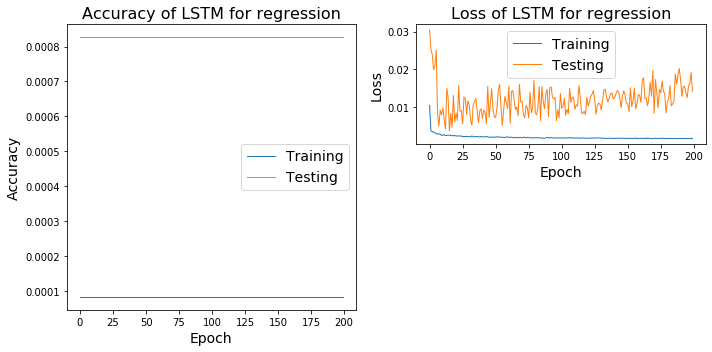

In [42]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.epoch, history.history['accuracy'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=1, label='Testing')
plt.title('Accuracy of LSTM for regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(222)
plt.plot(history.epoch, history.history['loss'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=1, label='Testing')
plt.title('Loss of LSTM for regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend(fontsize=14)


plt.tight_layout()

In [20]:
train_X, train_y, test_X, test_y = data(2)
model_lstm_final = optimal_model()
model_lstm_final.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(test_X, test_y), verbose=0)

In [58]:
def prediction (train_X, train_y, test_X, test_y, model):
    # faire la prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # inverser le scaling pour les données prédites
    inv_yhat = concatenate((yhat, test_X[:,:3]), axis=1) #concatenation column-wise
    inv_yhat = scaler.inverse_transform(inv_yhat) #the values were scaled before putting them into the neural networks, this operation makes the inverse operation so that the values are comprehensible
    inv_yhat = inv_yhat[:,0]

    # inverser le scaling pour les vraies valeurs 
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:,:3]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    #liste des valeurs du Low
    val_low_test = df_2013.iloc[limit+2:,4].values

    #liste des valeurs du High
    val_high_test = df_2013.iloc[limit+2:,3].values
    
    return(inv_yhat, inv_y, val_low_test, val_high_test)

def tracer_prediction_date(x, inv_yhat, inv_y, val_low_test, val_high_test):  #x est le nombre de points considérés
    plt.figure(figsize=(15, 9))
    plt.plot(val_date_test[:x], inv_yhat[:x], 'r', lw=1.5, label='Prediction')
    plt.plot(val_date_test[:x], inv_y[:x], 'b', lw=1.5, label='Valeur réelle')
    plt.plot(val_date_test[:x], val_low_test[:x], 'k--', lw=1, label='Low')
    plt.plot(val_date_test[:x], val_high_test[:x], 'k--', lw=1, label='High')
    plt.fill_between(val_date_test[:x], val_low_test[:x], val_high_test[:x], color='0.7')
    plt.legend(fontsize=14)
    plt.title('Comparaison entre les valeurs réelles et prédites par notre modèle', fontsize=16)
    plt.xlabel('Date et heure', fontsize=14)
    plt.ylabel('Valeur du Last', fontsize=14)
    plt.tight_layout()

def tracer_prediction_no_date(nb_points, inv_yhat, inv_y, val_low_test, val_high_test):  #nb_points est le nombre de points considérés
    plt.figure(figsize=(15, 9))
    x=np.linspace(1,nb_points,nb_points)
    plt.plot(x, inv_yhat[1:nb_points+1], 'r', lw=1.5, label='Prediction')
    plt.plot(x, inv_y[:nb_points], 'b', lw=1.5, label='Valeur réelle')
    plt.plot(x, val_low_test[:nb_points], 'k--', lw=1, label='Low')
    plt.plot(x, val_high_test[:nb_points], 'k--', lw=1, label='High')
    plt.fill_between(x, val_low_test[:nb_points], val_high_test[:nb_points], color='0.7')
    plt.legend(fontsize=14)
    plt.title('Comparaison entre les valeurs réelles et prédites par notre modèle', fontsize=16)
    plt.xlabel('Date et heure', fontsize=14)
    plt.ylabel('Valeur du Last', fontsize=14)
    plt.tight_layout()

def tracer_volumes_no_date (x, dataframe):
    #liste des valeurs du Volume
    val_volume = dataframe.iloc[limit+2:,6].values
    
    plt.figure(figsize=(15, 9))
    y=np.linspace(0,x,x)
    plt.plot(y, val_volume[:x], 'k', lw=1, label='Volume')
    plt.legend(fontsize=14)
    plt.title('Variation du volume', fontsize=16)
    plt.xlabel('Date et heure', fontsize=14)
    plt.ylabel('Valeur du volume', fontsize=14)
    plt.tight_layout()

In [3]:
train_X, train_y, test_X, test_y = data(2)
print(test_X.shape)
print(train_X.shape)
print(train_y.shape)
print(test_y.shape)
prediction1, reel1, low1, high1 = prediction(train_X, train_y, test_X, test_y, model_lstm_final)

NameError: name 'data' is not defined

In [1]:
tracer_prediction_no_date(100, prediction1, reel1, low1, high1)
#plt.savefig("Prédiction_timelag2.png")

NameError: name 'tracer_prediction_no_date' is not defined

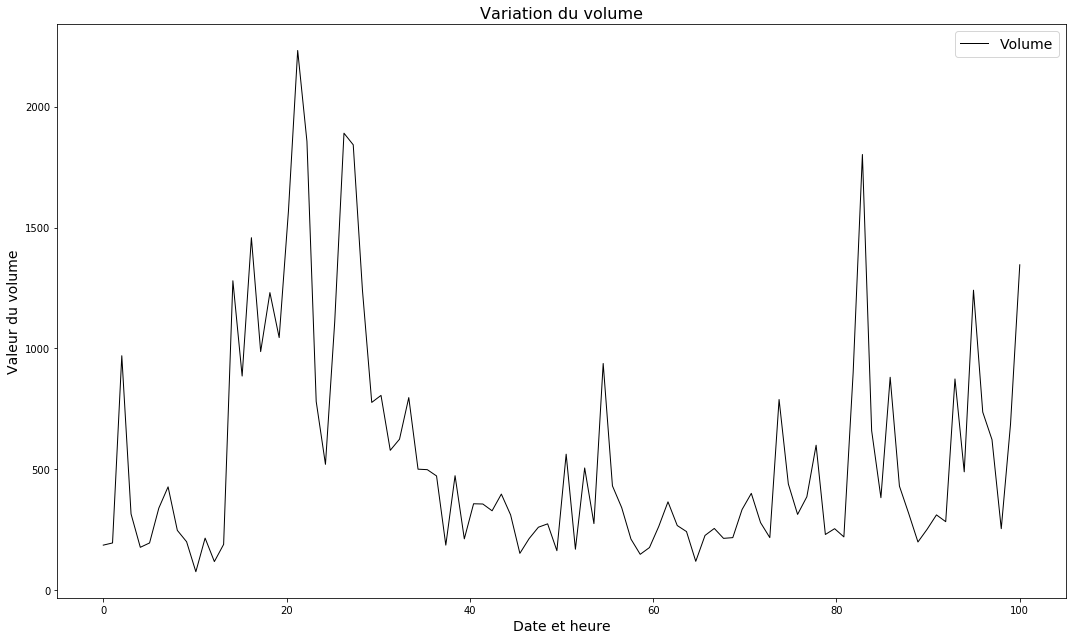

In [226]:
tracer_volumes_no_date(100, df_vol_2013)

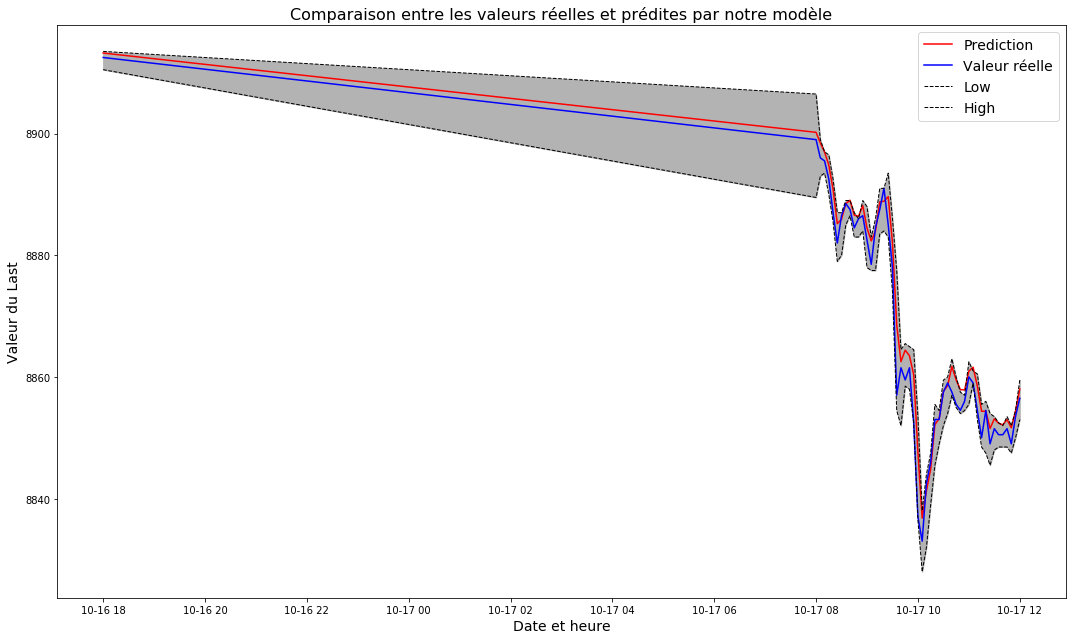

In [257]:
tracer_prediction_date(50, prediction1, reel1, low1, high1)

### <font color = darkblue> Création d'une fonction de classification </font>

Maintenant, construisons une fonction de classification permettant de connaître la nature de la bougie en se basant sur les données continues de prédication. Le principe est très simple et est le suivant : 
- Si $\hat{y}_t$ > $\hat{y}_{t-1}$

In [47]:
def classification (inv_yhat, dataframe, time_lag):
    df_2013_testing_set = dataframe.iloc[limit+time_lag:,:]
    Last_hat=[]
    Last_hat = inv_yhat
    df_2013_testing_set.insert(7,'Last_hat',Last_hat)
    Y_hat=[]
    n_test = df_2013_testing_set.shape[0]
    for i in range (1,n_test) : 
        if df_2013_testing_set.iloc[i,7]<df_2013_testing_set.iloc[i-1,7]:
            Y_hat.append(-1)
        if df_2013_testing_set.iloc[i,7]==df_2013_testing_set.iloc[i-1,7]:
            Y_hat.append(0)
        if df_2013_testing_set.iloc[i,7]>df_2013_testing_set.iloc[i-1,7]:
            Y_hat.append(1) 
    l = len(Y_hat)
    print("La longueur de la liste des labels prédit est : %s" %l)
    print("La longueur du dataframe est : %s" %n_test)
    df_2013_testing_set = df_2013_testing_set.iloc[1:,:]
    n_test=df_2013_testing_set.shape[0]
    print()
    print("La longueur de la liste des labels est : %s" %l)
    print("La longueur du dataframe privé de sa première ligne est : %s" %n_test)
    df_2013_testing_set.insert(8,'Y_hat',Y_hat)
    return (df_2013_testing_set)

In [192]:
df_err_1 = classification(prediction1, df_2013, 2)

La longueur de la liste des labels prédit est : 6050
La longueur du dataframe est : 6051

La longueur de la liste des labels est : 6050
La longueur du dataframe privé de sa première ligne est : 6050


,date_time,Time,Open,High,Low,Last,Y,Last_hat,Y_hat
24215,2013-10-17 08:00:00,1900-01-01 08:00:00,8892.5,8906.5,8889.5,8899.0,-1,8900.205966,-1
24216,2013-10-17 08:05:00,1900-01-01 08:05:00,8898.5,8899.0,8893.0,8896.0,-1,8898.449794,-1
24217,2013-10-17 08:10:00,1900-01-01 08:10:00,8895.0,8897.0,8893.5,8895.5,-1,8896.958137,-1
24218,2013-10-17 08:15:00,1900-01-01 08:15:00,8896.0,8896.5,8890.0,8892.5,-1,8894.831094,-1
24219,2013-10-17 08:20:00,1900-01-01 08:20:00,8892.5,8892.5,8885.5,8887.0,-1,8890.861961,-1
...,...,...,...,...,...,...,...,...,...
30260,2013-12-30 17:40:00,1900-01-01 17:40:00,9651.5,9654.0,9650.5,9652.5,1,9607.141230,1
30261,2013-12-30 17:45:00,1900-01-01 17:45:00,9652.0,9659.0,9652.0,9655.5,1,9609.672427,1
30262,2013-12-30 17:50:00,1900-01-01 17:50:00,9655.5,9658.5,9654.5,9658.0,1,9610.501422,1
30263,2013-12-30 17:55:00,1900-01-01 17:55:00,9658.0,9658.5,9655.0,9658.0,0,9610.736991,1


In [193]:
df_err_1.head(10)

,date_time,Time,Open,High,Low,Last,Y,Last_hat,Y_hat
24215,2013-10-17 08:00:00,1900-01-01 08:00:00,8892.5,8906.5,8889.5,8899.0,-1,8900.205966,-1
24216,2013-10-17 08:05:00,1900-01-01 08:05:00,8898.5,8899.0,8893.0,8896.0,-1,8898.449794,-1
24217,2013-10-17 08:10:00,1900-01-01 08:10:00,8895.0,8897.0,8893.5,8895.5,-1,8896.958137,-1
24218,2013-10-17 08:15:00,1900-01-01 08:15:00,8896.0,8896.5,8890.0,8892.5,-1,8894.831094,-1
24219,2013-10-17 08:20:00,1900-01-01 08:20:00,8892.5,8892.5,8885.5,8887.0,-1,8890.861961,-1
24220,2013-10-17 08:25:00,1900-01-01 08:25:00,8887.0,8887.0,8879.0,8882.0,-1,8885.206309,-1
24221,2013-10-17 08:30:00,1900-01-01 08:30:00,8881.5,8887.0,8880.0,8886.5,1,8885.928364,1
24222,2013-10-17 08:35:00,1900-01-01 08:35:00,8886.5,8889.0,8885.0,8888.5,1,8888.496764,1
24223,2013-10-17 08:40:00,1900-01-01 08:40:00,8888.0,8889.0,8886.5,8887.5,-1,8889.047981,1
24224,2013-10-17 08:45:00,1900-01-01 08:45:00,8887.0,8887.0,8883.0,8884.5,-1,8886.585937,-1


Regardons l'erreur maximale en terme de points. 

In [48]:
def calcul_erreur_max (df_err):
    n = df_err.shape[0]
    L_diff=[]
    for i in range (0,n):
        tmp = abs(df_err.iloc[i,5] - df_err.iloc[i,7])
        L_diff.append(tmp)
    maximum = max(L_diff)
    return(maximum)


In [195]:
max1 = calcul_erreur_max(df_err_1)
max1

54.56679308414459

Regardons l'erreur de classification

In [49]:
def calcul_erreur_classification (df_err):
    s = 0
    n = df_err.shape[0]
    for i in range (0,n):
        if df_err.iloc[i,6] != df_err.iloc[i,8]:
            s+=1
    erreur = s/n
    return(erreur)

In [200]:
err1 = calcul_erreur_classification(df_err_1)
err1

0.31074380165289256

In [201]:
del(df_err_1, max1, err1)

Maintenant, regardons s'il est possible de découvrir pourquoi l'erreur est si élevée. Nous allons réaliser les choses suivantes : 
- 1) calculer l'erreur par nature de bougie (l'erreur sur les bougies montantes, sur les bougies descendantes, etc ;
- 2) arrondir la valeur de prédiction du Last à sa valeur réelle la plus proche. En effet, le DAX varie de demi-point en demi-point, une prédiction avec 3 chiffres après la virgule n'a donc pas de sens. Regardons si la classification à partir de cette valeur retravaillée du Last prédit permet de changer l'erreur, en particulier l'erreur sur les bougies égales. 

In [54]:
err0, err1, err_neg = 0, 0, 0
y0 = (df_2013_testing_set['Y']==0).value_counts()
y1 = (df_2013_testing_set['Y']==1).value_counts()
yneg = (df_2013_testing_set['Y']==-1).value_counts()

for i in range (0, n_test):
    if df_2013_testing_set.iloc[i,6]==-1:
        if df_2013_testing_set.iloc[i,6]!=df_2013_testing_set.iloc[i,8]:
            err_neg+=1
    if df_2013_testing_set.iloc[i,6]==0:
        if df_2013_testing_set.iloc[i,6]!=df_2013_testing_set.iloc[i,8]:
            err0+=1
    if df_2013_testing_set.iloc[i,6]==1:
        if df_2013_testing_set.iloc[i,6]!=df_2013_testing_set.iloc[i,8]:
            err1+=1
            

err0 = err0/y0[1]
err1 = err1/y1[1]
err_neg = err_neg/yneg[1]

print("L'erreur de classification sur les bougies montantes est %s" %(err1))
print()
print("L'erreur de classification sur les bougies descendantes est %s" %(err_neg))
print()
print("L'erreur de classification sur les bougies égales est %s" %(err0))
print()

L'erreur de classification sur les bougies montantes est 0.24555903866248693

L'erreur de classification sur les bougies descendantes est 0.25984251968503935

L'erreur de classification sur les bougies égales est 1.0



Ce n'est pas étonnant de voir qu'aucune bougie égale n'a pu être prédite. Voyons si ça change en modifiant les valeurs prédites du Last. Voila comment nous procédons : 
- Si la décimale de Last_hat est comprise entre 0 et 0,25 ou entre 0,75 et 0,99 on arrondi à 0;
- Si la décimale de Last_hat est comprise entre 0,25 et 0,75 on arrondi à 0,5.

In [72]:
Last_hat_modif = []
for i in range (0, n_test):
    if ((df_2013_testing_set.iloc[i,7]*10)%10) <= 7.5 and ((df_2013_testing_set.iloc[i,7]*10)%10) >= 2.5:
        tmp = int(df_2013_testing_set.iloc[i,7])+0.5
        Last_hat_modif.append(tmp)
    if ((df_2013_testing_set.iloc[i,7]*10)%10) < 2.5:
        Last_hat_modif.append(int(df_2013_testing_set.iloc[i,7]))
    if ((df_2013_testing_set.iloc[i,7]*10)%10) > 7.5:
        tmp=int(df_2013_testing_set.iloc[i,7])+1
        Last_hat_modif.append(tmp)

In [83]:
df_2013_testing_set.insert(9,'Last_hat_modifi', Last_hat_modif)

,date_time,Time,Open,High,Low,Last,Y,Last_hat,Y_hat,Last_hat_modifi,Last_hat_modif
24215,2013-10-17 08:00:00,1900-01-01 08:00:00,8892.5,8906.5,8889.5,8899.0,-1,8896.066996,-1,8896.0,8896
24216,2013-10-17 08:05:00,1900-01-01 08:05:00,8898.5,8899.0,8893.0,8896.0,-1,8893.810491,-1,8894.0,8893
24217,2013-10-17 08:10:00,1900-01-01 08:10:00,8895.0,8897.0,8893.5,8895.5,-1,8893.482663,-1,8893.5,8893
24218,2013-10-17 08:15:00,1900-01-01 08:15:00,8896.0,8896.5,8890.0,8892.5,-1,8891.193792,-1,8891.0,8891
24219,2013-10-17 08:20:00,1900-01-01 08:20:00,8892.5,8892.5,8885.5,8887.0,-1,8887.106541,-1,8887.0,8887
24220,2013-10-17 08:25:00,1900-01-01 08:25:00,8887.0,8887.0,8879.0,8882.0,-1,8881.478500,-1,8881.5,8881
24221,2013-10-17 08:30:00,1900-01-01 08:30:00,8881.5,8887.0,8880.0,8886.5,1,8882.586607,1,8882.5,8882
24222,2013-10-17 08:35:00,1900-01-01 08:35:00,8886.5,8889.0,8885.0,8888.5,1,8885.125978,1,8885.0,8885
24223,2013-10-17 08:40:00,1900-01-01 08:40:00,8888.0,8889.0,8886.5,8887.5,-1,8885.545314,1,8885.5,8885
24224,2013-10-17 08:45:00,1900-01-01 08:45:00,8887.0,8887.0,8883.0,8884.5,-1,8882.952306,-1,8883.0,8882


In [88]:
df_2013_testing_set.drop(['Last_hat_modif'], axis=1, inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
df_2013_testing_set

,date_time,Time,Open,High,Low,Last,Y,Last_hat,Y_hat,Last_hat_modifi
24215,2013-10-17 08:00:00,1900-01-01 08:00:00,8892.5,8906.5,8889.5,8899.0,-1,8896.066996,-1,8896.0
24216,2013-10-17 08:05:00,1900-01-01 08:05:00,8898.5,8899.0,8893.0,8896.0,-1,8893.810491,-1,8894.0
24217,2013-10-17 08:10:00,1900-01-01 08:10:00,8895.0,8897.0,8893.5,8895.5,-1,8893.482663,-1,8893.5
24218,2013-10-17 08:15:00,1900-01-01 08:15:00,8896.0,8896.5,8890.0,8892.5,-1,8891.193792,-1,8891.0
24219,2013-10-17 08:20:00,1900-01-01 08:20:00,8892.5,8892.5,8885.5,8887.0,-1,8887.106541,-1,8887.0
...,...,...,...,...,...,...,...,...,...,...
30260,2013-12-30 17:40:00,1900-01-01 17:40:00,9651.5,9654.0,9650.5,9652.5,1,9599.979573,1,9600.0
30261,2013-12-30 17:45:00,1900-01-01 17:45:00,9652.0,9659.0,9652.0,9655.5,1,9602.648240,1,9602.5
30262,2013-12-30 17:50:00,1900-01-01 17:50:00,9655.5,9658.5,9654.5,9658.0,1,9603.153078,1,9603.0
30263,2013-12-30 17:55:00,1900-01-01 17:55:00,9658.0,9658.5,9655.0,9658.0,0,9603.450208,1,9603.5


In [91]:
Y_hat_modif=[]
n_test = df_2013_testing_set.shape[0]
for i in range (1,n_test) : 
    if df_2013_testing_set.iloc[i,9]<df_2013_testing_set.iloc[i-1,9]:
        Y_hat_modif.append(-1)
    if df_2013_testing_set.iloc[i,9]==df_2013_testing_set.iloc[i-1,9]:
        Y_hat_modif.append(0)
    if df_2013_testing_set.iloc[i,9]>df_2013_testing_set.iloc[i-1,9]:
        Y_hat_modif.append(1) 

In [92]:
l = len(Y_hat_modif)
print("La longueur de la liste des labels prédit est : %s" %l)
print("La longueur du dataframe est : %s" %n_test)
df_2013_testing_set = df_2013_testing_set.iloc[1:,:]
n_test=df_2013_testing_set.shape[0]
print()
print("La longueur de la liste des labels est : %s" %l)
print("La longueur du dataframe privé de sa première ligne est : %s" %n_test)

La longueur de la liste des labels prédit est : 6049
La longueur du dataframe est : 6050

La longueur de la liste des labels est : 6049
La longueur du dataframe privé de sa première ligne est : 6049


In [93]:
df_2013_testing_set.insert(10,'Y_hat_modif',Y_hat_modif)

In [94]:
df_2013_testing_set.head(10)

,date_time,Time,Open,High,Low,Last,Y,Last_hat,Y_hat,Last_hat_modifi,Y_hat_modif
24216,2013-10-17 08:05:00,1900-01-01 08:05:00,8898.5,8899.0,8893.0,8896.0,-1,8893.810491,-1,8894.0,-1
24217,2013-10-17 08:10:00,1900-01-01 08:10:00,8895.0,8897.0,8893.5,8895.5,-1,8893.482663,-1,8893.5,-1
24218,2013-10-17 08:15:00,1900-01-01 08:15:00,8896.0,8896.5,8890.0,8892.5,-1,8891.193792,-1,8891.0,-1
24219,2013-10-17 08:20:00,1900-01-01 08:20:00,8892.5,8892.5,8885.5,8887.0,-1,8887.106541,-1,8887.0,-1
24220,2013-10-17 08:25:00,1900-01-01 08:25:00,8887.0,8887.0,8879.0,8882.0,-1,8881.478500,-1,8881.5,-1
24221,2013-10-17 08:30:00,1900-01-01 08:30:00,8881.5,8887.0,8880.0,8886.5,1,8882.586607,1,8882.5,1
24222,2013-10-17 08:35:00,1900-01-01 08:35:00,8886.5,8889.0,8885.0,8888.5,1,8885.125978,1,8885.0,1
24223,2013-10-17 08:40:00,1900-01-01 08:40:00,8888.0,8889.0,8886.5,8887.5,-1,8885.545314,1,8885.5,1
24224,2013-10-17 08:45:00,1900-01-01 08:45:00,8887.0,8887.0,8883.0,8884.5,-1,8882.952306,-1,8883.0,-1
24225,2013-10-17 08:50:00,1900-01-01 08:50:00,8884.5,8886.0,8883.0,8886.0,1,8882.943047,-1,8883.0,0


In [95]:
k = 0
for i in range (0,n_test):
    if df_2013_testing_set.iloc[i,6] != df_2013_testing_set.iloc[i,10]:
        k+=1
erreur_modifiée = k/n_test
erreur_modifiée

0.33013721276244007

Il y'a donc davantage d'erreurs lorsqu'on réalise une approximation de la valeur continue du Last prédite. Regardons maintenant plus près d'où viennent les erreurs en calculant l'erreur par nature de bougie. 

In [96]:
err0, err1, err_neg = 0, 0, 0
for i in range (0, n_test):
    if df_2013_testing_set.iloc[i,6]==-1:
        if df_2013_testing_set.iloc[i,6]!=df_2013_testing_set.iloc[i,10]:
            err_neg+=1
    if df_2013_testing_set.iloc[i,6]==0:
        if df_2013_testing_set.iloc[i,6]!=df_2013_testing_set.iloc[i,10]:
            err0+=1
    if df_2013_testing_set.iloc[i,6]==1:
        if df_2013_testing_set.iloc[i,6]!=df_2013_testing_set.iloc[i,10]:
            err1+=1
            

err0 = err0/y0[1]
err1 = err1/y1[1]
err_neg = err_neg/yneg[1]

print("L'erreur de classification sur les bougies montantes est %s" %(err1))
print()
print("L'erreur de classification sur les bougies descendantes est %s" %(err_neg))
print()
print("L'erreur de classification sur les bougies égales est %s" %(err0))
print()

L'erreur de classification sur les bougies montantes est 0.28770463253221873

L'erreur de classification sur les bougies descendantes est 0.3006442376521117

L'erreur de classification sur les bougies égales est 0.8597402597402597



Sur l'intégralité des données de test, nous obtenons environ 70% de bonnes prédictions sur la nature de la bougie à l'instant $t$ en considérant les valeurs du tape aux instants $t-2$ et $t-1$.

# <font color=darkred> Partie 3 : Mise en place d'un LSTM en ne considérant pas les variables à l'instant t </font>

### <font color = darkblue> Prédiction du Last sans considérer les features à l'instant $t$ </font>

Maintenant, on refait le même travail en ne considérant aucune donnée à l'instant $t$. En effet, les modèles précédents prenaient en input le High, le Low, l'Open à l'instant $t$ pour prédire le Last à l'instant $t$, ce qui n'a pas de sens, puisque la valeur du High et du Low par exemple ne peuvent s'acquérir qu'à la fin du laps de temps de 5min définissant la bougie. Et donc, si on a accès au High et au Low à l'instant $t$, on a nécessairement le Last. 

L'objectif de cette partie est de prédire la valeur du Last $y_t$ à l'instant $t$ en fonction des observations précédentes. A chaque pas de temps, la valeur estimée de $y_t$ qu'on note $\hat{y}_t$, est obtenue en utilisant l'état caché à l'instant précédent $h_{t-1}$ et les données d'entrée $x_t$ à l'instant $t$. Ces données en entrée correspondent aux 4 features Open, High, Low et Last.
En fonction du pas de temps considéré, les données d'entrée ne seront pas les mêmes. Voici un exemple : 
- $time$_$lag = 1$ : les données d'entrée sont constituées des variables Open, High, Low, Last à l'instant $t-1$ uniquement
- $time$_$lag = 2$ : les données d'entrée sont constituées de ces 4 même features aux instants $t-1$ et $t-2$.


### <font color = darkblue> On commence par timelag = 2 pour comparer au résultat précédent </font>

In [50]:
def data_new (time_lag): #time_lag = parameter to design how many time steps to consider in the input data 
    ndrop=time_lag*4
    scaled = normalized
    print(scaled.shape[0])
    processed_data_lstm = build_dataset(scaled, time_lag, 1)
    processed_data_lstm.drop(processed_data_lstm.columns[[ndrop, ndrop+1, ndrop+2]], axis=1, inplace=True)
    print(processed_data_lstm.shape[0])
    
    # split into train and test sets
    values = processed_data_lstm.values  #values is a numpy representation of processed_data, which is data normalized for prediction
    print(len(values))
    train = values[:limit, :]
    test = values[limit:, :]
    
    # split into input and outputs
    X_train_lstm, Y_train_lstm = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
    X_test_lstm, Y_test_lstm = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))
    return(X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm)  

In [51]:
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = data_new(2)
print('x_train shape:', X_train_lstm.shape)
print('x_test shape:', X_test_lstm.shape)
print('y_train shape:', Y_train_lstm.shape)
print('y_test shape:', Y_test_lstm.shape)

30264
30262
30262
x_train shape: (24211, 1, 8)
x_test shape: (6051, 1, 8)
y_train shape: (24211,)
y_test shape: (6051,)


In [35]:
train_X, train_y, test_X, test_y = data_new(2)
model_lstm_final_new = optimal_model()
model_lstm_final_new.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(test_X, test_y), verbose=0)

30264
30262
30262


NameError: name 'optimal_model' is not defined

In [27]:
#y_predict = model_lstm_final_new.predict(test_X)
print(y_predict)

[[0.9956032 ]
 [0.99606043]
 [0.9866599 ]
 ...
 [1.4898767 ]
 [1.4909045 ]
 [1.4909244 ]]


In [47]:
train_X, train_y, test_X, test_y = data_new(2)
print(test_X.shape)
print(train_X.shape)
print(train_y.shape)
print(test_y.shape)
prediction, reel, low, high = prediction(train_X, train_y, test_X, test_y, model_lstm_final_new)
pred_shape = prediction.shape[0]
reel_shape = reel.shape[0]
print(pred_shape)
print(reel_shape)

30264
30262
30262
(6051, 1, 8)
(24211, 1, 8)
(24211,)
(6051,)
6051
6051


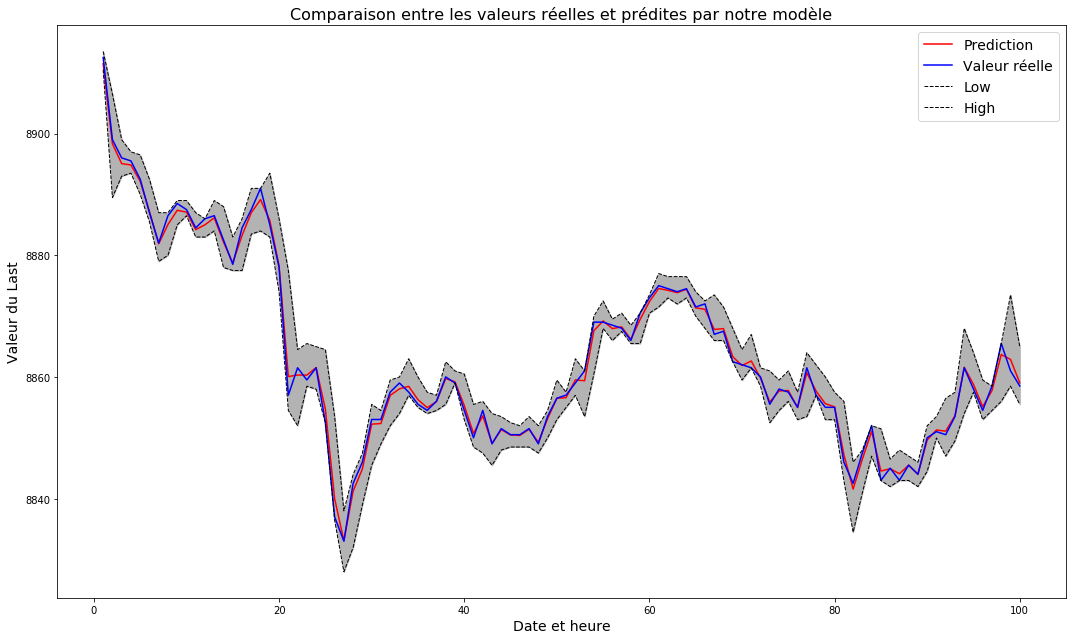

In [48]:
tracer_prediction_no_date(100, prediction, reel, low, high)
#plt.savefig("Prédiction_timelag2_modifié_nouveau.png")

In [34]:
rmse_oui = sqrt(mean_squared_error(prediction, reel))
rmse_oui = rmse_oui/len(reel)
rmse_oui

NameError: name 'reel' is not defined

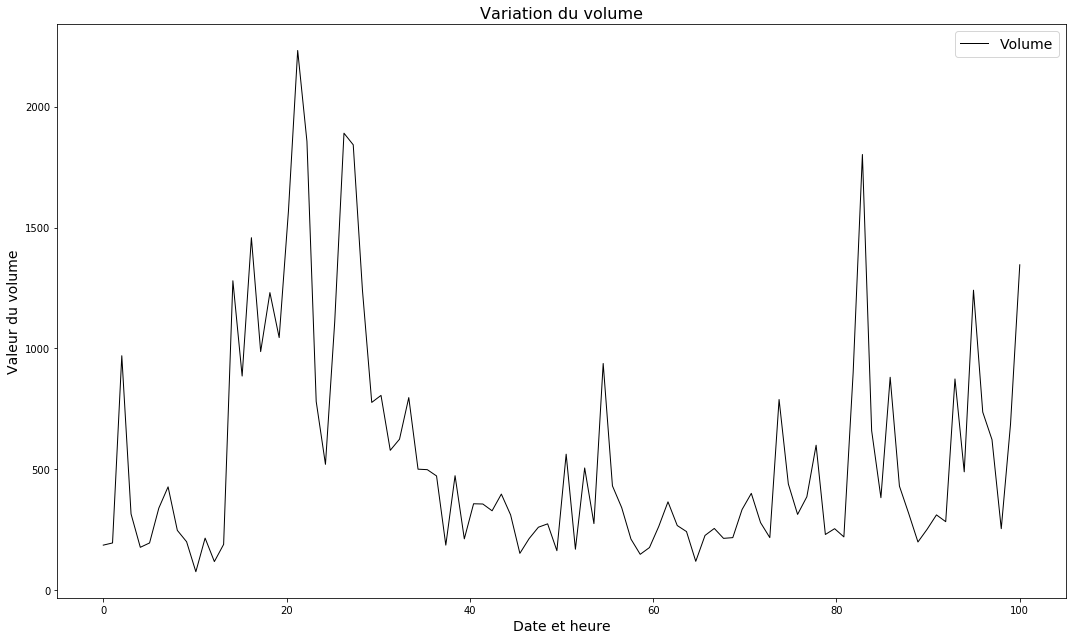

In [244]:
tracer_volumes_no_date(100, df_vol_2013)

### <font color = darkblue> Calcul de l'erreur </font>

In [40]:
df_err = classification(prediction, df_2013, 2)
max1 = calcul_erreur_max(df_err)
err = calcul_erreur_classification(df_err)
print("L'erreur maximale en nombre de points est : %s" %max1)
print()
print("L'erreur de classification en pourcentage est : %s" %err)

NameError: name 'classification' is not defined

In [203]:
df_err.head(10)

,date_time,Time,Open,High,Low,Last,Y,Last_hat,Y_hat
24215,2013-10-17 08:00:00,1900-01-01 08:00:00,8892.5,8906.5,8889.5,8899.0,-1,8910.021776,1
24216,2013-10-17 08:05:00,1900-01-01 08:05:00,8898.5,8899.0,8893.0,8896.0,-1,8896.714894,-1
24217,2013-10-17 08:10:00,1900-01-01 08:10:00,8895.0,8897.0,8893.5,8895.5,-1,8893.881729,-1
24218,2013-10-17 08:15:00,1900-01-01 08:15:00,8896.0,8896.5,8890.0,8892.5,-1,8893.719734,-1
24219,2013-10-17 08:20:00,1900-01-01 08:20:00,8892.5,8892.5,8885.5,8887.0,-1,8891.010276,-1
24220,2013-10-17 08:25:00,1900-01-01 08:25:00,8887.0,8887.0,8879.0,8882.0,-1,8886.298567,-1
24221,2013-10-17 08:30:00,1900-01-01 08:30:00,8881.5,8887.0,8880.0,8886.5,1,8881.089444,-1
24222,2013-10-17 08:35:00,1900-01-01 08:35:00,8886.5,8889.0,8885.0,8888.5,1,8884.007027,1
24223,2013-10-17 08:40:00,1900-01-01 08:40:00,8888.0,8889.0,8886.5,8887.5,-1,8886.061080,1
24224,2013-10-17 08:45:00,1900-01-01 08:45:00,8887.0,8887.0,8883.0,8884.5,-1,8885.815834,-1


In [234]:
del(df_err, max1, err)

# <font color=darkred> Partie 4 : Ajout d'une deuxième couche cachée pour le LSTM </font>

In [52]:
def optimal_model_2_layers():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss = 'mae', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return(model)

In [53]:
train_X, train_y, test_X, test_y = data_new(2)
model_lstm_final_2_layers = optimal_model_2_layers()
model_lstm_final_2_layers.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(test_X, test_y), verbose=0)

30264
30262
30262


In [54]:
train_X, train_y, test_X, test_y = data_new(2)
print(test_X.shape)
print(train_X.shape)
print(train_y.shape)
print(test_y.shape)
prediction2, reel2, low2, high2 = prediction(train_X, train_y, test_X, test_y, model_lstm_final_2_layers)

30264
30262
30262
(6051, 1, 8)
(24211, 1, 8)
(24211,)
(6051,)


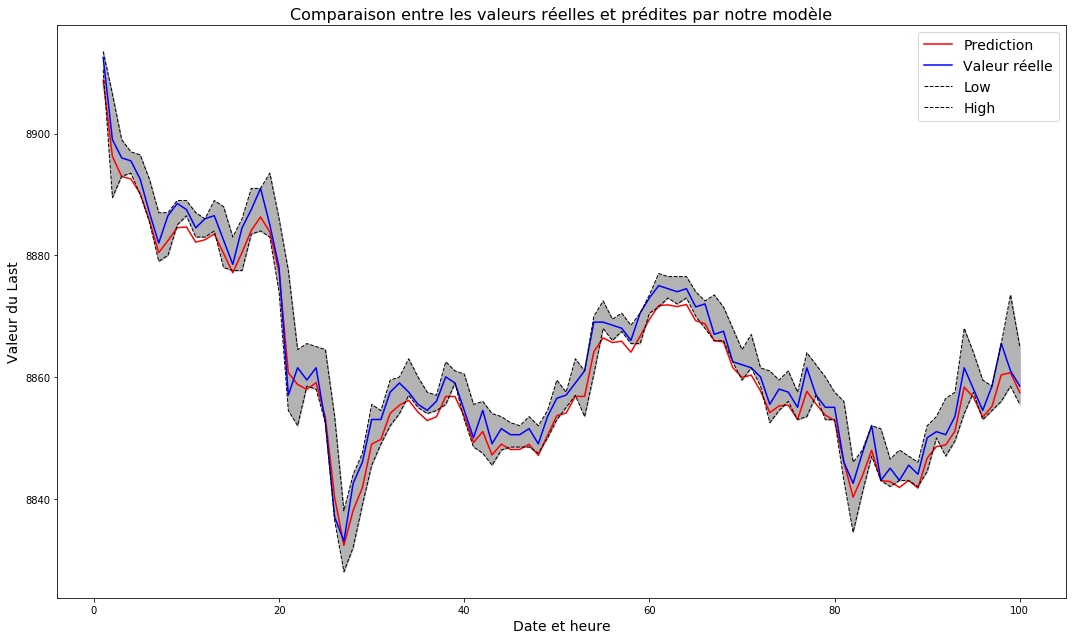

In [59]:
tracer_prediction_no_date(100, prediction2, reel2, low2, high2)
plt.savefig("Prédiction_timelag2_2_layers.png")

In [60]:
rmse = sqrt(mean_squared_error(prediction2, reel2))
rmse = rmse/len(reel2)
rmse

0.004526408582757558

In [33]:
df_err = classification(prediction2, df_2013, 2)
print()
max1 = calcul_erreur_max(df_err)
err = calcul_erreur_classification(df_err)
print("L'erreur maximale en nombre de points est : %s" %max1)
print()
print("L'erreur de classification en pourcentage est : %s" %err)

La longueur de la liste des labels prédit est : 6050
La longueur du dataframe est : 6051

La longueur de la liste des labels est : 6050
La longueur du dataframe privé de sa première ligne est : 6050

L'erreur maximale en nombre de points est : 148.351855635643

L'erreur de classification en pourcentage est : 0.5742148760330579


### <font color = darkblue> En fait changement de bord, faisons de la classification directement </font>

Nous allons changer la variable $y_t$ de prédiction qui devient $Y$, c'est-à-dire la nature de la bougie (haussière, baissière, …). Nous devons donc changer les donner pour prendre en compte la colonne $Y$ qui avait été omise dans l'apprentissage dans le cas précédent. Réalisons donc le pré-processing des données comme suit : 

In [120]:
time_lag = 0
scaled = values_processed
processed_data_lstm = build_dataset(scaled, time_lag, 1)
processed_data_lstm.head(10)

,var1(t),var2(t),var3(t),var4(t),var5(t)
0,0.230439,0.229433,0.237522,0.229286,-1.0
1,0.228653,0.226241,0.234690,0.228214,-1.0
2,0.227939,0.228014,0.236460,0.230357,1.0
3,0.230439,0.228014,0.237522,0.228571,-1.0
4,0.228296,0.229787,0.237168,0.231071,1.0
5,0.230797,0.229078,0.238938,0.230714,-1.0
6,0.230439,0.228723,0.238938,0.230714,0.0
7,0.230439,0.228723,0.238230,0.230714,0.0
8,0.230439,0.229787,0.238938,0.232500,1.0
9,0.231869,0.230851,0.239646,0.232857,1.0


In [121]:
values = processed_data_lstm.values
train = values[:limit, :]
test = values[limit:, :]

# split into input and outputs
X_train_lstm_other, Y_train_lstm_other = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
X_test_lstm_other, Y_test_lstm_other = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
X_train_lstm_other = X_train_lstm_other.reshape((X_train_lstm_other.shape[0], 1, X_train_lstm_other.shape[1]))
X_test_lstm_other = X_test_lstm_other.reshape((X_test_lstm_other.shape[0], 1, X_test_lstm_other.shape[1]))

#one-hot encoding of categorical values
num_class = 3
Y_train_lstm_other = to_categorical(Y_train_lstm_other, num_class)
Y_test_lstm_other = to_categorical(Y_test_lstm_other, num_class)

In [122]:
print('x_train shape:', X_train_lstm_other.shape)
print('x_test shape:', X_test_lstm_other.shape)
print('y_train shape:', Y_train_lstm_other.shape)
print('y_test shape:', Y_test_lstm_other.shape)

x_train shape: (24211, 1, 4)
x_test shape: (6053, 1, 4)
y_train shape: (24211, 3)
y_test shape: (6053, 3)


In [123]:
Y_test_lstm_other

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [124]:
model = Sequential()
model.add(LSTM(10, input_shape=(X_train_lstm_other.shape[1], X_train_lstm_other.shape[2])))
model.add(Dense(3, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam', 
              metrics=['accuracy'])

In [128]:
batch_size = 64 #mettre batch size = 256
epochs = 200
history = model.fit(X_train_lstm_other, Y_train_lstm_other,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = 1,
                    validation_data=(X_test_lstm_other, Y_test_lstm_other))
score = model.evaluate(X_test_lstm_other, Y_test_lstm_other, verbose = 1)

Train on 24211 samples, validate on 6053 samples
Epoch 1/200
24211/24211 [==============================] - 1s 32us/step - loss: 0.8569 - accuracy: 0.5013 - val_loss: 0.8973 - val_accuracy: 0.4746
Epoch 2/200
24211/24211 [==============================] - 1s 31us/step - loss: 0.8569 - accuracy: 0.4983 - val_loss: 0.8897 - val_accuracy: 0.4746
Epoch 3/200
24211/24211 [==============================] - 1s 33us/step - loss: 0.8569 - accuracy: 0.5075 - val_loss: 0.8945 - val_accuracy: 0.4746
Epoch 4/200
24211/24211 [==============================] - 1s 31us/step - loss: 0.8568 - accuracy: 0.5067 - val_loss: 0.8929 - val_accuracy: 0.4746
Epoch 5/200
24211/24211 [==============================] - 1s 32us/step - loss: 0.8568 - accuracy: 0.4963 - val_loss: 0.8930 - val_accuracy: 0.4746
Epoch 6/200
24211/24211 [==============================] - 1s 31us/step - loss: 0.8565 - accuracy: 0.5014 - val_loss: 0.8969 - val_accuracy: 0.4746
Epoch 7/200
24211/24211 [==============================] - 1s 3

Epoch 56/200
24211/24211 [==============================] - 1s 30us/step - loss: 0.8421 - accuracy: 0.6331 - val_loss: 0.8740 - val_accuracy: 0.4882
Epoch 57/200
24211/24211 [==============================] - 1s 30us/step - loss: 0.8414 - accuracy: 0.6358 - val_loss: 0.8775 - val_accuracy: 0.4654
Epoch 58/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.8408 - accuracy: 0.6504 - val_loss: 0.8749 - val_accuracy: 0.4779
Epoch 59/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.8399 - accuracy: 0.6712 - val_loss: 0.8765 - val_accuracy: 0.4783
Epoch 60/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.8393 - accuracy: 0.6492 - val_loss: 0.8712 - val_accuracy: 0.5113
Epoch 61/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.8383 - accuracy: 0.6315 - val_loss: 0.8717 - val_accuracy: 0.5610
Epoch 62/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.8377 - accuracy: 0.6495

Epoch 165/200
24211/24211 [==============================] - 1s 30us/step - loss: 0.5949 - accuracy: 0.8771 - val_loss: 0.7333 - val_accuracy: 0.6104
Epoch 166/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.5950 - accuracy: 0.8634 - val_loss: 0.7137 - val_accuracy: 0.6496
Epoch 167/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.5906 - accuracy: 0.8758 - val_loss: 0.6673 - val_accuracy: 0.8444
Epoch 168/200
24211/24211 [==============================] - 1s 30us/step - loss: 0.5868 - accuracy: 0.8831 - val_loss: 0.7124 - val_accuracy: 0.6433
Epoch 169/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.5867 - accuracy: 0.8666 - val_loss: 0.6776 - val_accuracy: 0.7448
Epoch 170/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.5837 - accuracy: 0.8761 - val_loss: 0.6586 - val_accuracy: 0.8592
Epoch 171/200
24211/24211 [==============================] - 1s 29us/step - loss: 0.5793 - accuracy:

Test loss: 0.6005028767781121
Test accuracy: 0.8612258434295654


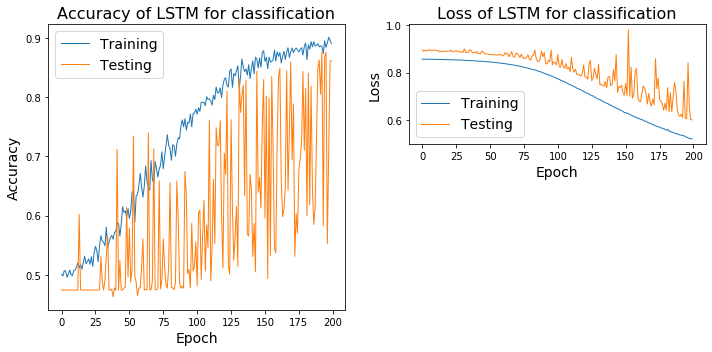

In [130]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.epoch, history.history['accuracy'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=1, label='Testing')
plt.title('Accuracy of LSTM for classification', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(222)
plt.plot(history.epoch, history.history['loss'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=1, label='Testing')
plt.title('Loss of LSTM for classification', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend(fontsize=14)


plt.tight_layout()

Considérons des valeurs de $time$_$lag$ supérieures à 0 pour obtenir de meilleurs résultats. Pour cela nous construisons la fonction $data$ qui permet de récupérer les samples d'entrainement (X_train_lstm, Y_train_lstm) et de test (X_test_lstm, Y_test_lstm) en fonction du pas de temps que l'on souhaite considérer : $time$_$lag$. 

Nous allons chercher les meilleurs hyper-paramètres pour ce modèle en considérant à chaque fois un time_lag différent. Nous ne ferons varier que la dimension de la couche cachée. 

In [147]:
def data (time_lag): #time_lag = parameter to design how many time steps to consider in the input data 
    scaled = values_processed
    processed_data_lstm = build_dataset(scaled, time_lag, 1)
    # split into train and test sets
    values = processed_data_lstm.values  #values is a numpy representation of processed_data, which is data normalized for prediction
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    X_train_lstm, Y_train_lstm = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
    X_test_lstm, Y_test_lstm = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))
    #one-hot encoding of categorical values
    num_class = 3
    Y_train_lstm = to_categorical(Y_train_lstm, num_class)
    Y_test_lstm = to_categorical(Y_test_lstm, num_class)

    return(X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm)  

def modelling(lstm_dim=4):
    model = Sequential()
    model.add(LSTM(lstm_dim, input_shape=(X_train_lstm.shape[1], X_test_lstm.shape[2])))
    model.add(Dense(3, activation = 'softmax'))
    model.compile(loss = 'mae', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return(model)


In [148]:
a, b, c, d = data(1)
time_lag = 1
scaled1 = values_processed
processed_data_lstm1 = build_dataset(scaled1, time_lag, 1)
#processed_data_lstm1
d

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [151]:
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = data(1)
estimator_lstm = KerasClassifier(build_fn=modelling, batch_size=64, epochs=50) #Faire sur bcp plus d'epochs
param_grid_lstm = {'lstm_dim': [4, 8, 16, 32, 64, 128, 256, 512]}
clf_lstm = GridSearchCV(estimator=estimator_lstm, param_grid=param_grid_lstm, n_jobs=-1, cv = 3)
clf_lstm.fit(X_train_lstm, Y_train_lstm)

print("Best parameters set found on development set for the LSTM cross-validation:")
print()
print(clf_lstm.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf_lstm.cv_results_['mean_test_score']
stds = clf_lstm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_lstm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Epoch 1/50
24211/24211 [==============================] - 2s 88us/step - loss: 0.3519 - accuracy: 0.4937
Epoch 2/50
24211/24211 [==============================] - 2s 72us/step - loss: 0.3356 - accuracy: 0.4999
Epoch 3/50
24211/24211 [==============================] - 2s 70us/step - loss: 0.3343 - accuracy: 0.4999
Epoch 4/50
24211/24211 [==============================] - 2s 71us/step - loss: 0.3339 - accuracy: 0.4999
Epoch 5/50
24211/24211 [==============================] - 2s 71us/step - loss: 0.3337 - accuracy: 0.4999
Epoch 6/50
24211/24211 [==============================] - 2s 70us/step - loss: 0.3336 - accuracy: 0.4999
Epoch 7/50
24211/24211 [==============================] - 2s 70us/step - loss: 0.3335 - accuracy: 0.4999
Epoch 8/50
24211/24211 [==============================] - 2s 70us/step - loss: 0.3335 - accuracy: 0.4999
Epoch 9/50
24211/24211 [==============================] - 2s 70us/step - loss: 0.3334 - accuracy: 0.4999
Epoch 10/50
24211/24211 [==============================

In [152]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_lstm_other.shape[1], X_train_lstm_other.shape[2])))
model.add(Dense(3, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
batch_size = 64
epochs = 200
history = model.fit(X_train_lstm_other, Y_train_lstm_other,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = 1,
                    validation_data=(X_test_lstm_other, Y_test_lstm_other))
score = model.evaluate(X_test_lstm_other, Y_test_lstm_other, verbose = 1)